In [ ]:
%pylab inline

In [4]:
from pyspark import SparkContext, SparkConf
from datetime import datetime
from timeit import timeit


hello


In [1]:
tweetDataFrame = sqlContext.read.json('group_assignment/tweets/tweets_extended.json')
tweetDataFrame.printSchema()

root
 |-- created_at: long (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |-- sizes: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = tr

(1, 12)

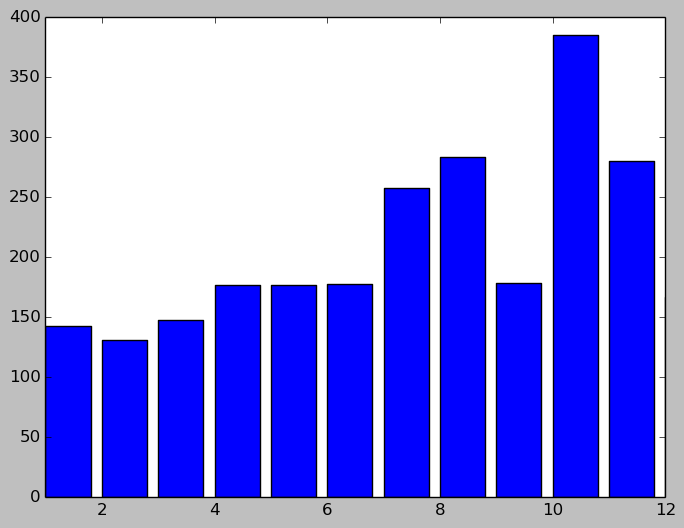

In [9]:
"""
group by date month tweets
"""
import datetime

dates = tweetDataFrame.select('created_at').map(lambda x: datetime.datetime.fromtimestamp(x[0] / 1e3))
dates = dates.groupBy(lambda x: x.month).sortByKey()
dates = dates.map(lambda x : (x[0], len(list(x[1])))).collect()
x,y = zip(*dates)

import matplotlib.pyplot as plt
plt.figure()
plt.bar(x,y)
plt.xlim(1,12)






In [157]:
"""
TOYING WITH RETWEETED STATUS AND DATES
"""
import datetime
from pyspark.sql import Row
import numpy as np
"""
HELPER FUNCTIONS FOR retweets per tweets
"""
def aggregate_retweet_per_tweet(aggregated_dict, twitter_struct):
    if twitter_struct['id'] in aggregated_dict:
        aggregated_dict[twitter_struct['id']] += twitter_struct['retweet_number']
        return aggregated_dict
    
    aggregated_dict[twitter_struct['id']] = twitter_struct['retweet_number']
    return aggregated_dict
    
"""
execute
"""
retweets_per_tweet = tweetDataFrame.selectExpr('id','retweeted_status.id as r_id')
retweets_per_tweet = retweets_per_tweet.map(lambda x: {'id' : x.id, 'retweet_number' : 1 if x.r_id else 0}).collect()
retweets_per_tweet = reduce(aggregate_retweet_per_tweet, retweets_per_tweet,{}) #going for normal python data type
retweets_per_tweet = np.mean([retweets_per_tweet[id] for id in retweets_per_tweet])
print retweets_per_tweet #prints averga


"""
HELPER FUNCTIONS FOR DELTA DAYS
"""
def clean_up_row(row):
    """
    cleans up row and return new row object
    """
    return Row(
        id=row.id,
        created_at=convert_long_date(row.created_at),
        retweeted_at=convert_date_string(row.retweeted_at),
        )

def convert_long_date(long_date):
    return datetime.datetime.fromtimestamp(long_date / 1e3)

def convert_date_string(date_string):
    """
    converts e.g. 2015-01-31 12:30:30 +0000
    """
    if not date_string:
        return None
    return datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S +0000')

def convert_retweeted_at_to_days_since_original_tweet(row):
    """
    returns new Row(id, created_at, retweeted_at_delta in minutes)
    """
    delta = row.created_at - row.retweeted_at
    delta =( delta.days * 24 * 60) + (delta.seconds/60) #in minutes
    
    return Row(
        id=row.id,
        created_at=row.created_at,
        retweeted_at_delta=delta
        )

def collect_retweeted_days_to_array(row):
    """
    expects Row(id, iterable(Row(created_at, id, retweeted_at_delta_1), ..., Row(created_at, id, retweeted_at_delta_n))
    returns [retweeted_at_delta_1, ..., retweeted_at_delta_n]
    """
    return [days for days in row[0]]

"""
Execute query
"""
test = tweetDataFrame.selectExpr('id','created_at', 'retweeted_status.created_at as retweeted_at')
test = test.map(lambda x:  clean_up_row(x))
test = test.filter(lambda x: True if x.retweeted_at else False) #remove empty rows (no retweet)
test = test.map(lambda x: convert_retweeted_at_to_days_since_original_tweet(x))
test = test.groupBy(lambda x: x.id) #group al retweets 
test = test.collect()




0.0


In [38]:
"""
EXTRACTING THE MMA TWEETS
"""
import re

def filter_mma(row):
    """
    filters mma row
    """
    #variable contains list of meaningful MMA expressions, after cleaning expressions such as
    #u'TOMMARRS', u'DILEMMA', u'SUMMARY', u'MUHAMMAD_WAKAS',u'SUMMARIZING', u'SUMMARIZED' ....
    
    mma_accepted = ['MMA_BLOG', 'SMMMAGAZINE', 'MMA_CRM', 'MMA'] 
    
    #start matching
    regex_p =  r'(\w*%s\w*)' % 'MMA'
    results = re.findall(regex_p, row.text.upper())
    
    #now see if one of the expression is an 'accepted' expression
    results = [r for r in results if r in mma_accepted]
    
    if len(results) > 0:
        return True
    return False
    
    

mma_tweets = tweetDataFrame.selectExpr('id', 'created_at', 'text').rdd
mma_tweets = mma_tweets.filter(lambda x: filter_mma(x)).collect()

for t in mma_tweets:
    print t.text +  '\n'




Kick-off of #rstats in my Advanced Predictive #Analytics class of @hir_me and @MMA_CRM by @MatthBogaert and Steven http://t.co/zWJYW4fyLH

.@KirkDBorne @itknowingness @MktngDistillery @nlehuen @Yclaeyssen Not necessarily. See http://t.co/iXZcIJA1bo @MMA_CRM @HIR_ME

www.mma.ugent.be was first predictive analytics degree RT @marcosluis2186 Prepare to fill 1.5M data-savvy manager jobs http://t.co/gF0PtUy1

enjoyed his introductory class of analytical CRM using predictive #analytics today with the new MMA & ME students: http://t.co/8rcZxFHJ

#FF thanks @jocoutuer
@nisssamsi
@b2bspecialist
@ProfessorBrey
@andressilvaa
@kenthuffman
@bobbikay
@barack_JRS
@SMMmagazine

is happy with the performance of MMA students on SAS Certification exam. The best student obtained a score of 92/100 ! http://bit.ly/gFcwH2

Kick-off of #rstats in my Advanced Predictive #Analytics class of @hir_me and @MMA_CRM by @MatthBogaert and Steven http://t.co/zWJYW4fyLH

.@KirkDBorne @itknowingness @MktngDistillery @nle

In [ ]:
"""
Correlating MMA tweets and 
"""

def filter_mma_tweet_date_